# Autoencoder for elliptic bitcoin dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, silhouette_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [25]:
# Import data

edgelist = pd.read_csv('../data/elliptic_txs_edgelist.csv')
data = pd.read_csv('../data/merged_df.csv')

In [26]:
data['class'] = data['class'].map({'licit': 0, 'illicit': 1, 'unknown': 'unknown'})
data = data[data['class'] != 'unknown']

In [5]:
# Create autoencoder with 3 hidden layers of 50 neurons each 

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(165, 50),
            nn.ReLU(True),
            nn.Linear(50, 50),
            nn.ReLU(True),
            nn.Linear(50, 50),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(True),
            nn.Linear(50, 50),
            nn.ReLU(True),
            nn.Linear(50, 165),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [27]:
# Create train and test sets

X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
# Create train and test sets for autoencoder
y_train_ae = X_train['class']
y_test_ae = X_test['class']

X_train_ae = X_train.drop(['txId', 'Time step', 'class'], axis=1)
X_test_ae = X_test.drop(['txId', 'Time step', 'class'], axis=1)

# Convert to tensors

X_train_ae = torch.tensor(X_train_ae.values).float()
X_test_ae = torch.tensor(X_test_ae.values).float()

In [8]:
# Create autoencoder

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train autoencoder

num_epochs = 300
outputs = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    outputs = model(X_train_ae)
    loss = criterion(outputs, X_train_ae)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    if epoch % 1 == 0:
        print("Epoch: %d, Loss: %1.5f" % (epoch, train_loss))

Epoch: 0, Loss: 2.12702
Epoch: 1, Loss: 2.12588
Epoch: 2, Loss: 2.12469
Epoch: 3, Loss: 2.12344
Epoch: 4, Loss: 2.12209
Epoch: 5, Loss: 2.12054
Epoch: 6, Loss: 2.11873
Epoch: 7, Loss: 2.11661
Epoch: 8, Loss: 2.11410
Epoch: 9, Loss: 2.11108
Epoch: 10, Loss: 2.10741
Epoch: 11, Loss: 2.10292
Epoch: 12, Loss: 2.09744
Epoch: 13, Loss: 2.09080
Epoch: 14, Loss: 2.08279
Epoch: 15, Loss: 2.07317
Epoch: 16, Loss: 2.06174
Epoch: 17, Loss: 2.04833
Epoch: 18, Loss: 2.03291
Epoch: 19, Loss: 2.01573
Epoch: 20, Loss: 1.99736
Epoch: 21, Loss: 1.97889
Epoch: 22, Loss: 1.96218
Epoch: 23, Loss: 1.94967
Epoch: 24, Loss: 1.94249
Epoch: 25, Loss: 1.93808
Epoch: 26, Loss: 1.93118
Epoch: 27, Loss: 1.91920
Epoch: 28, Loss: 1.90403
Epoch: 29, Loss: 1.88920
Epoch: 30, Loss: 1.87697
Epoch: 31, Loss: 1.86715
Epoch: 32, Loss: 1.85890
Epoch: 33, Loss: 1.85093
Epoch: 34, Loss: 1.84195
Epoch: 35, Loss: 1.83147
Epoch: 36, Loss: 1.82009
Epoch: 37, Loss: 1.80878
Epoch: 38, Loss: 1.79840
Epoch: 39, Loss: 1.78929
Epoch: 40,

In [10]:
# Test autoencoder

with torch.no_grad:
    test_outputs = model(X_test_ae)
    test_loss = criterion(test_outputs, X_test_ae)
print("Test loss: %1.5f" % (test_loss.item()))

TypeError: 'type' object does not support the context manager protocol

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Use the encoder part of the autoencoder to transform the train and test data
model.eval()
with torch.no_grad():
    X_train_transformed = model.encoder(X_train_ae)
    X_test_transformed = model.encoder(X_test_ae)

# Train a classifier on the transformed data
clf = LogisticRegression()
clf.fit(X_train_transformed, y_train_ae)

# Predict the labels of the test set
y_pred = clf.predict(X_test_transformed)

# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test_ae, y_pred)
print('Classifier accuracy: ', accuracy)

ValueError: Input contains NaN

In [14]:
# Create an LSTM model

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, input):
        batch_size = input.size(0)
        lstm_out, _ = self.lstm(input.view(batch_size, -1, self.input_dim))  # view function is used to reshape the tensor
        # lstm_out holds the output of the last layer for all timesteps, with shape [batch_size, seq_len, hidden_dim]
        # we take the output from the last timestep with lstm_out[:, -1, :]
        y_pred = self.linear(lstm_out[:, -1, :])
        return y_pred


In [29]:
# Create train and test sets for LSTM

y_train_lstm = X_train['class']
y_test_lstm = X_test['class']

X_train_lstm = X_train.drop(['txId', 'Time step', 'class'], axis=1)
X_test_lstm = X_test.drop(['txId', 'Time step', 'class'], axis=1)


In [28]:
X_train

,txId,Time step,local_feature_0,local_feature_1,local_feature_2,local_feature_3,local_feature_4,local_feature_5,local_feature_6,local_feature_7,...,aggregate_feature_63,aggregate_feature_64,aggregate_feature_65,aggregate_feature_66,aggregate_feature_67,aggregate_feature_68,aggregate_feature_69,aggregate_feature_70,aggregate_feature_71,class
151261,29537769,37,-0.172621,-0.000089,1.018602,-0.046932,-0.043875,-0.029140,-0.061584,-0.163581,...,-0.405468,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
53017,68445296,10,-0.170374,-0.158783,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163004,...,-0.607306,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,0
172993,33688530,42,0.007529,0.058183,1.573595,-0.121970,0.015676,-0.113002,-0.061584,0.021051,...,0.196261,1.079633,0.929817,-0.098889,0.200877,0.308331,0.178147,-0.935247,-1.551046,0
126763,222565628,32,-0.172955,-0.116952,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163615,...,0.054975,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,0
116506,139656143,28,-0.119723,-0.127192,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.109151,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50189,179139605,9,-0.151527,-0.187360,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,-0.141693,...,-0.468543,1.461330,1.461369,0.018279,4.699400,11.442631,10.627774,1.519700,1.521399,0
193048,187407716,46,-0.172954,0.088777,1.573595,-0.121970,-0.043875,-0.113002,-0.061584,-0.163609,...,1.581374,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,0
168465,72029285,42,-0.172958,0.071102,1.018602,-0.046932,-0.024025,-0.113002,0.242712,-0.163646,...,-0.563154,-0.979074,-0.978556,0.018279,-0.068266,-0.084674,-0.054450,1.519700,1.521399,0
3081,208587985,1,-0.172688,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.163344,...,2.067047,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,0


In [31]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# Create train and test sets for autoencoder
y_train_lstm = X_train['class']
y_test_lstm = X_test['class']

X_train_lstm = X_train.drop(['txId', 'Time step', 'class'], axis=1)
X_test_lstm = X_test.drop(['txId', 'Time step', 'class'], axis=1)

# Convert to tensors

X_train_lstm = torch.tensor(X_train_lstm.values).float()
X_test_lstm = torch.tensor(X_test_lstm.values).float()

y_train_lstm = y_train_lstm.astype('int')
y_test_lstm = y_test_lstm.astype('int')

y_train_lstm = torch.tensor(y_train_lstm.values).long()
y_test_lstm = torch.tensor(y_test_lstm.values).long()

In [32]:
# Create LSTM

model = LSTM(input_dim=X_train_lstm.size(-1), hidden_dim=50, output_dim=1, num_layers=2)
model = model.float()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [33]:
y_train_lstm

tensor([0, 0, 0,  ..., 0, 0, 0])

In [35]:
epoch_list = []
losses_list = []
accuracy_list = []

In [36]:
# Train LSTM
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_lstm)
    loss = criterion(outputs.view(-1), y_train_lstm.float())
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    model.eval()
    with torch.no_grad():
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total = y_train_lstm.size(0)
        correct = (predicted.view(-1) == y_train_lstm.float()).sum().item()
        accuracy = 100 * correct / total

    if epoch % 10 == 0:
        print('Epoch: %d, Loss: %.5f, Accuracy: %.2f%%' % (epoch, loss.item(), accuracy))
        epoch_list.append(epoch)
        losses_list.append(loss.item())
        accuracy_list.append(accuracy)


Epoch: 0, Loss: 0.65640, Accuracy: 90.21%
Epoch: 10, Loss: 0.61795, Accuracy: 90.21%
Epoch: 20, Loss: 0.55785, Accuracy: 90.21%
Epoch: 30, Loss: 0.46395, Accuracy: 90.21%
Epoch: 40, Loss: 0.35667, Accuracy: 90.21%
Epoch: 50, Loss: 0.27325, Accuracy: 90.24%
Epoch: 60, Loss: 0.22229, Accuracy: 90.88%
Epoch: 70, Loss: 0.19217, Accuracy: 93.40%
Epoch: 80, Loss: 0.17285, Accuracy: 95.00%
Epoch: 90, Loss: 0.15920, Accuracy: 95.67%
Epoch: 100, Loss: 0.14880, Accuracy: 96.05%
Epoch: 110, Loss: 0.14032, Accuracy: 96.43%
Epoch: 120, Loss: 0.13300, Accuracy: 96.75%
Epoch: 130, Loss: 0.12641, Accuracy: 96.94%
Epoch: 140, Loss: 0.12029, Accuracy: 97.09%
Epoch: 150, Loss: 0.11448, Accuracy: 97.23%
Epoch: 160, Loss: 0.10890, Accuracy: 97.36%
Epoch: 170, Loss: 0.10343, Accuracy: 97.46%
Epoch: 180, Loss: 0.09809, Accuracy: 97.53%
Epoch: 190, Loss: 0.09296, Accuracy: 97.58%
Epoch: 200, Loss: 0.08807, Accuracy: 97.65%
Epoch: 210, Loss: 0.08347, Accuracy: 97.75%
Epoch: 220, Loss: 0.07916, Accuracy: 97.82%

In [38]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_lstm)
    predicted = (torch.sigmoid(outputs) > 0.5).float()
    total = len(y_test_lstm) 
    correct = (predicted.view(-1) == torch.Tensor(y_test_lstm).float()).sum().item()
    print('Test Accuracy: %f %%' % (100 * correct / total))


Test Accuracy: 98.056480 %


In [39]:
# Save the LSTM model to a file
torch.save(model.state_dict(), '../models/lstm_model.pt')

In [40]:
# Load the LSTM model from a file
model = LSTM(input_dim=X_train_lstm.size(-1), hidden_dim=50, output_dim=1, num_layers=2)
model.load_state_dict(torch.load('../models/lstm_model.pt'))
model.eval()

LSTM(
  (lstm): LSTM(165, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

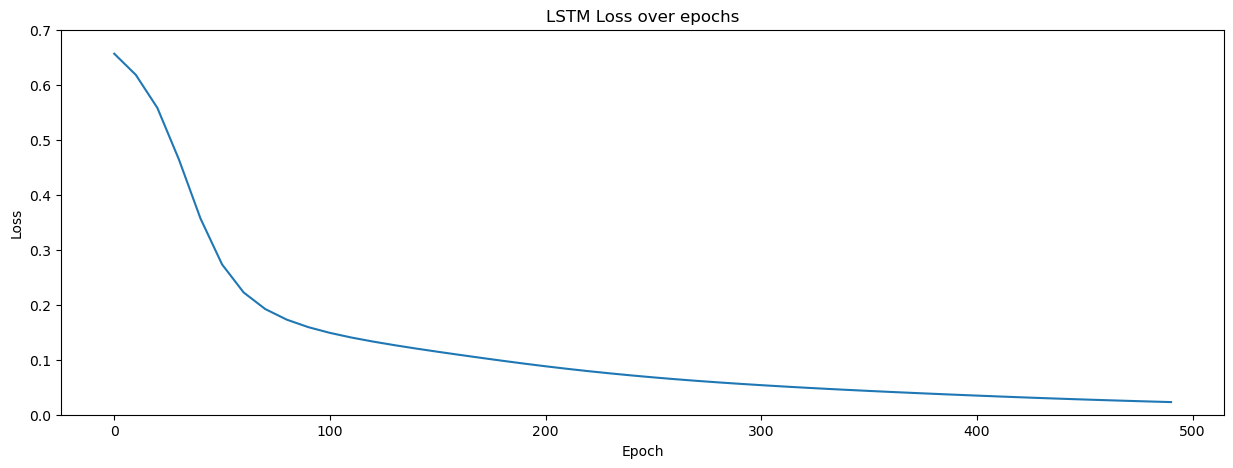

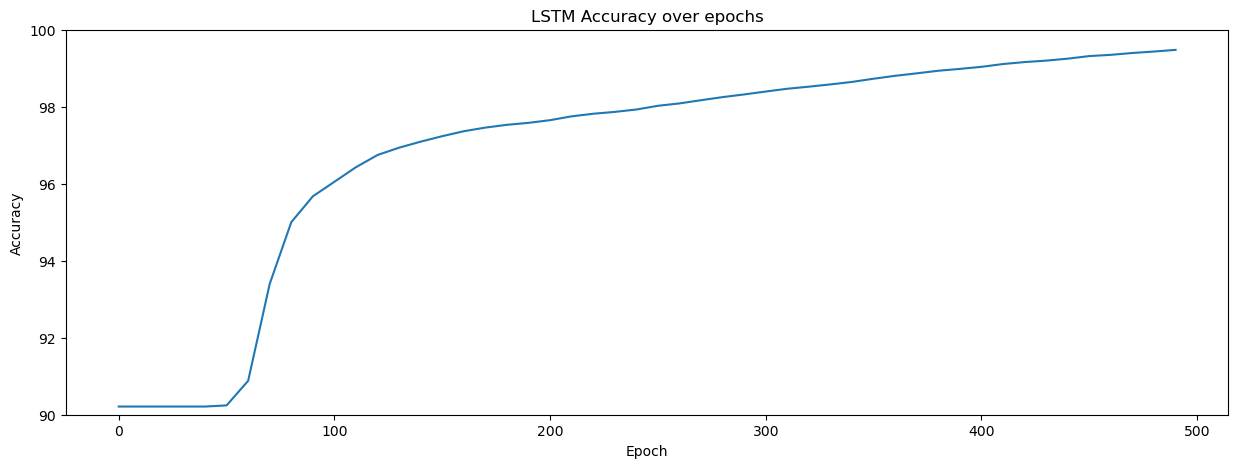

In [54]:
# Create a graph of the accuracy over the epochs
plt.figure(figsize=(15, 5))
plt.title('LSTM Loss over epochs')
plt.plot(epoch_list, losses_list)
plt.ylim(0,0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(15, 5))
plt.title('LSTM Accuracy over epochs')
plt.plot(epoch_list, accuracy_list)
plt.ylim(90,100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

